# (21) ca awake -- tSNR

**Motivation**: Temporal SNR plots. <br>

In [1]:
# HIDE CODE


import os, sys
from IPython.display import display

# tmp & extras dir
git_dir = os.path.join(os.environ['HOME'], 'Dropbox/git')
extras_dir = os.path.join(git_dir, 'jb-Ca-fMRI/_extras')
fig_base_dir = os.path.join(git_dir, 'jb-Ca-fMRI/figs')
tmp_dir = os.path.join(git_dir, 'jb-Ca-fMRI/tmp')

# GitHub
sys.path.insert(0, os.path.join(git_dir, '_Ca-fMRI'))
from figures.fighelper import *
from analysis.final import *
from utils.render import *

# warnings, tqdm, & style
warnings.filterwarnings('ignore', category=DeprecationWarning)
from tqdm.notebook import tqdm
%matplotlib inline
set_style()

In [2]:
def _read(s: str):
    return ants.image_read(pjoin(raw_dir, s))


def _compute(data: dict):
    mu = {
        i: x.mean(-1) for
        i, x in data.items()
    }
    sd = {
        i: x.std(-1) for
        i, x in data.items()
    }
    snr = {
        i: x / sd[i] for 
        i, x in mu.items()
    }
    snr = {
        i: x * np.sign(max(
            np.nanmin(x),
            np.nanmax(x),
            key=abs,
        )) for i, x in snr.items()
    }
    gs = {
        i: x[sd[i] > 0].mean(0)
        for i, x in data.items()
    }
    return mu, sd, snr, gs


def _show_snr(snr):
    ncols = 4
    nrows = len(snr) + 1
    nrows = int(np.ceil(nrows / ncols))
    fig, axes = create_figure(nrows, ncols, (6.4, nrows * 1.5), layout='constrained')
    trim_axs(axes, len(snr) + 1)
    remove_ticks(axes, False)

    for i, (run_i, x) in enumerate(snr.items()):
        x2p = filter_boundaries(x, np.isfinite(x))
        ax = axes.flat[i]
        ax.imshow(x2p, cmap='Spectral')
    x2p, _m = filter_boundaries([ref, m], m)
    x2p = mwh(~_m, x2p)
    ax = axes.flat[i + 1]
    ax.imshow(x2p, cmap='Greys_r')
    fig.suptitle(f"sub-SLC{sub:02d}", y=1.1, fontsize=16)
    plt.show()


raw_dir = '/mnt/storage/hadi/Ca-fMRI/raw'
tsnr_dir = '/home/hadi/Documents/Ca-fMRI/processed/temporalSNR'

## Which subs

In [3]:
files = sorted(filter(
    lambda s: 'awake' in s,
    os.listdir(raw_dir),
))
subs = [
    int(re.findall(r'\d+', f.split('_')[0]).pop())
    for f in files
]
subs = [
    k for k, v in collections.Counter(subs).items()
    if k <= 10 and v >= 9
]
subs

[2, 6, 7, 9, 10]

## Plot tSNR

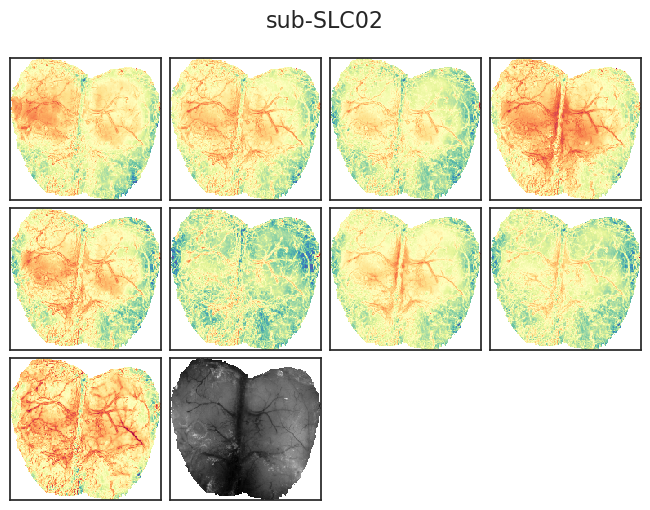

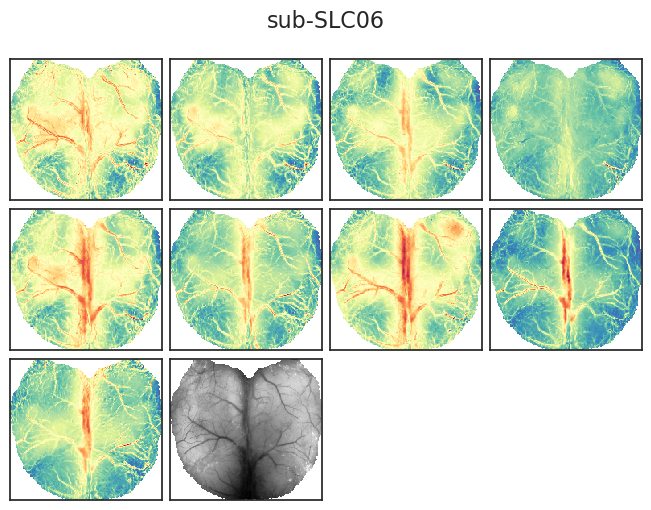

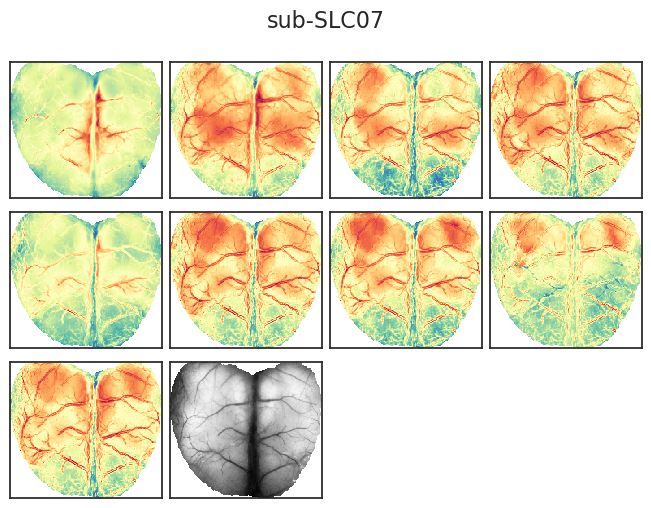

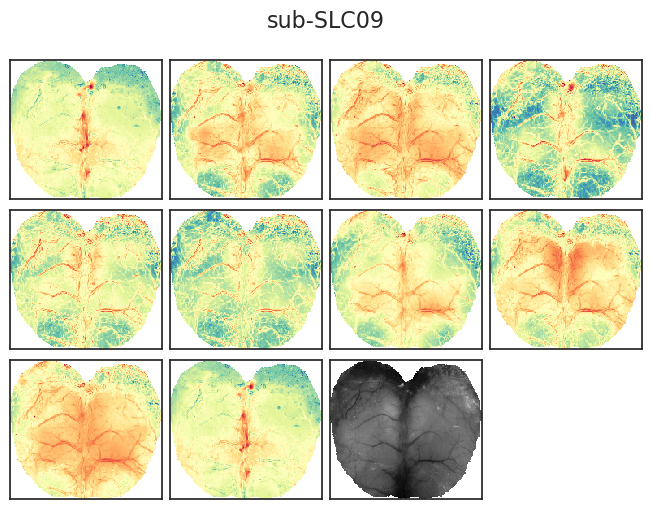

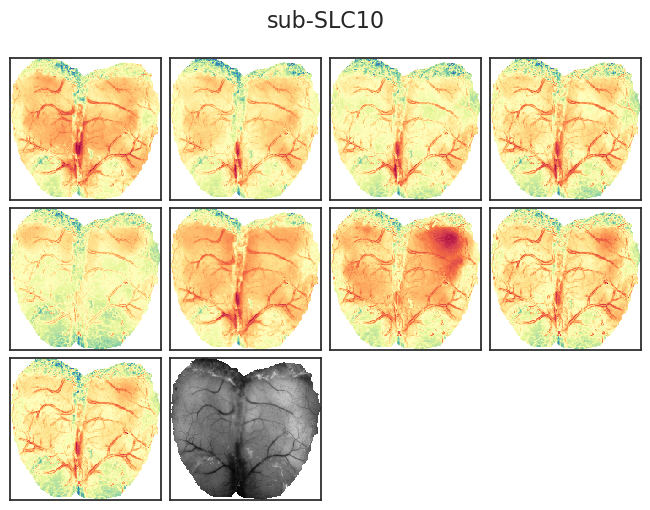

CPU times: user 9min 29s, sys: 3min 5s, total: 12min 35s
Wall time: 12min 48s


In [4]:
%%time


for sub in subs:
    files = sorted(filter(
        lambda f: 'ca2' in f and 
        f"sub-SLC{sub:02d}" in f
        and 'ses-4' in f,
        os.listdir(raw_dir),
    ))
    # load mask
    m = next(f for f in files if 'mask' in f)
    m = _read(m).numpy().astype(bool)
    # load ref img
    ref = next(f for f in files if 'referenceimage' in f)
    ref = _read(ref).numpy().astype(float)
    # load runs
    data = [f for f in files if 'run' in f]
    data = {
        i: _read(next(
            f for f in data
            if f"run-{i}" in f
        )).numpy()[..., 0, :]
        for i in range(1, len(data) + 1)
    }
    mu, sd, snr, gs = _compute(data)
    _show_snr(snr)
    
    # save
    for run in data:
        results = {
            'mu': mu[run],
            'sd': sd[run],
            'tSNR': snr[run],
            'gs': gs[run],
        }
        fname = '_'.join([
            f"sub-SLC{sub:02d}",
            'ses-4',
            f"run-{run}",
            'space-individual',
            'desc-tsnr',
            'ca2',
        ])
        save_obj(
            obj=results,
            file_name=fname,
            save_dir=tsnr_dir,
            verbose=False,
            mode='npy',
        )

In [13]:
name = 'sub-SLC02_ses-4_run-3_space-individual_desc-tsnr_ca2.npy'
x = np.load(pjoin(tsnr_dir, name), allow_pickle=True).item()
list(x)

['mu', 'sd', 'tSNR', 'gs']

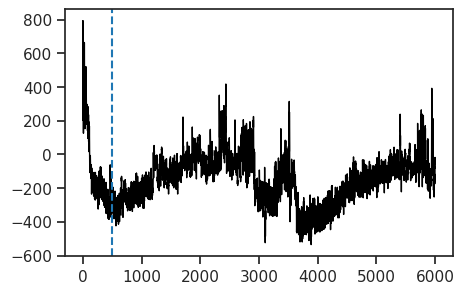

In [14]:
plt.plot(x['gs'], color='k', lw=1.)
plt.axvline(500, color='C0', ls='--');

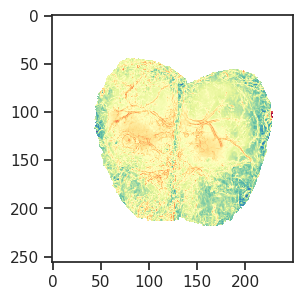

In [16]:
plt.imshow(x['tSNR'], cmap='Spectral');

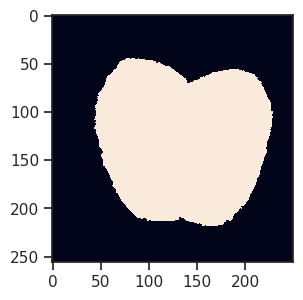

In [17]:
plt.imshow(x['sd'] > 0);